1201


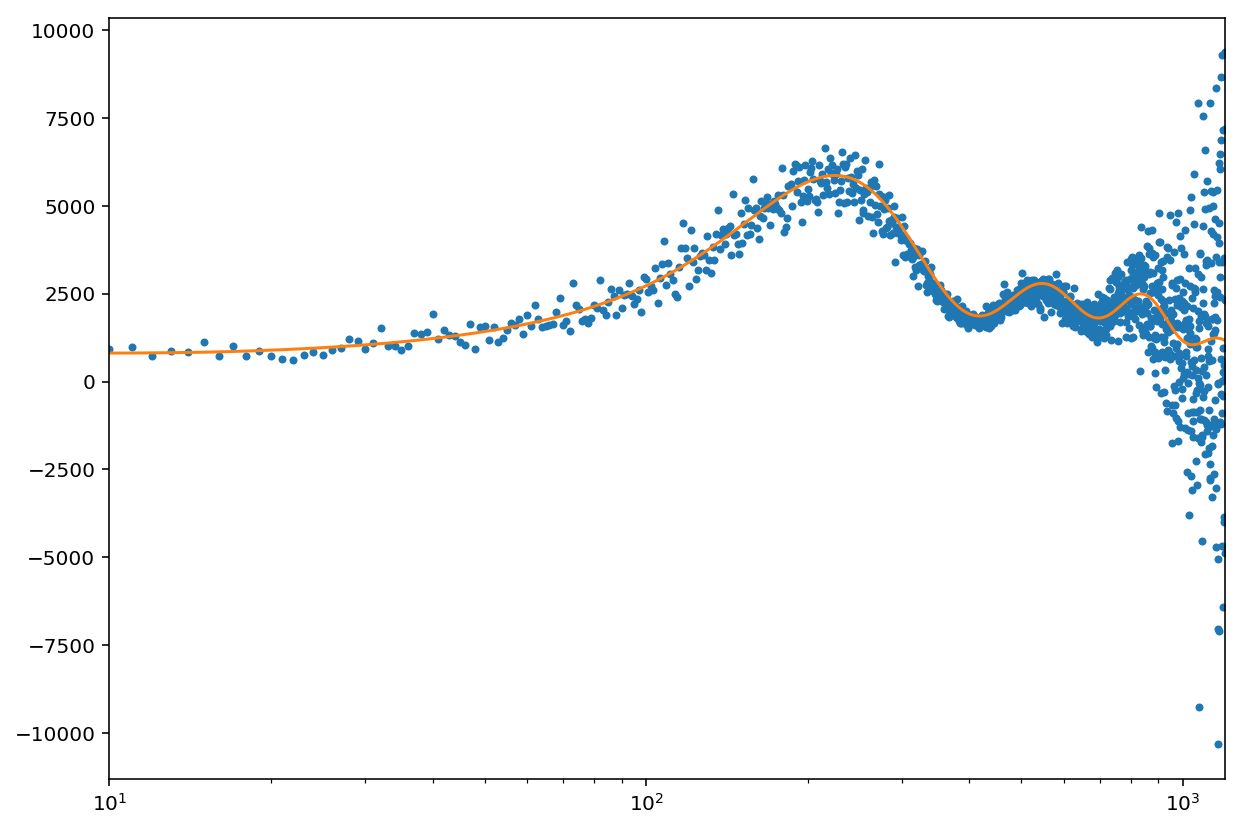

In [1]:
#This cell is the example given in the problem set

import numpy as np
import camb
from matplotlib import pyplot as plt
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = [10, 7]


pars0=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')


def get_spectrum(pars0,lmax=np.size(wmap[:,0])):
    #print('pars are ',pars)
    H0=pars0[0]
    ombh2=pars0[1]
    omch2=pars0[2]
    tau=pars0[3]
    As=pars0[4]
    ns=pars0[5]
    pars0=camb.CAMBparams()
    pars0.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars0.InitPower.set_params(As=As,ns=ns,r=0)
    pars0.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars0)
    powers=results.get_cmb_power_spectra(pars0,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt



plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum(pars0)
#plt.fill_between(wmap[:,0], cmb[:np.size(wmap[:,2])]-wmap[:,2],cmb[:np.size(wmap[:,2])]+wmap[:,2],color='grey',alpha=0.5)
plt.plot(cmb)
plt.xscale('log')
plt.xlim(10,1200)
print(cmb.size)

# Problem 1)

Assuming gaussian, uncorrelated errors what is $\chi^2$ for the above model?

In [2]:
running_sum=0
for e, val in enumerate(wmap[:,1]):
    running_sum+= ((cmb[e]-val)**2.0)/wmap[:,2][e]**2.0
    
print("chi2 for example model = %.3f"%running_sum)

chi2 for example model = 1676.676


# Problem 2)

Now let's write a Newton's method minimizer for the model. 

In [55]:
'''
The idea is to:
1. Calculate the spectrum (using get_spectrum) 
2. Vary one parameter by some amount dx
3. Recalculate the spectrum
4. Take the difference between the old and new spectrum and divide by our dx

To choose an appropriate dx draw from knowledge in our assignment 1... 
So let's do the derivative for dx = 1e-1, 1e-2 1e-3 ...to 1e-6
'''
def calc_deriv(func, pars, par_to_der, dp=1e-8):#calculates the derivative for a given parameter
    derivatives = []
    pars0 = pars.copy()
    
    dp = pars[par_to_der]/200 
    pars[par_to_der]+= dp 
    
    
    newr = np.array(func(pars)) #right side
    pars[par_to_der]-= 2.0*dp #2.0 to overcome above addition
    
    newl = func(pars) #left side
    pars[par_to_der]+= dp #back to normal
    
    derivatives=(((newr) - (newl))/(2.0*dp)) #two sided derivative wrt par_der

    return derivatives 

def newton_helper(grad_matrix, residuals, noiseMat, lamb_par):
    grad_matrix=np.matrix(grad_matrix)
    grad_matrix=np.transpose(grad_matrix) #to make it (1199,6) and fix dimensions
    noiseMat = np.linalg.inv(np.matrix(noiseMat))
    curv = grad_matrix.transpose()*noiseMat*grad_matrix
    
    lhs = curv + np.diag(np.diag(curv))*lamb_par
    rhs=grad_matrix.transpose()*noiseMat*residuals
    dpars=np.linalg.inv(lhs)*(rhs)

    return dpars    

Iteration 0 of 1000: 
The parameters are currently array([6.99270903e+01, 2.14846075e-02, 1.05033266e-01, 5.00000000e-02,
       1.98021141e-09, 9.59758713e-01])
Giving a chi2 of: 1251.17 

Iteration 1 of 1000: 
The parameters are currently array([7.03295722e+01, 2.24635615e-02, 1.10752953e-01, 5.00000000e-02,
       2.00100857e-09, 9.70652460e-01])
Giving a chi2 of: 1233.35 

Iteration 2 of 1000: 
The parameters are currently array([6.98507023e+01, 2.24986379e-02, 1.12517130e-01, 5.00000000e-02,
       2.01715695e-09, 9.70582303e-01])
Giving a chi2 of: 1232.02 

Iteration 3 of 1000: 
The parameters are currently array([6.93044776e+01, 2.24778333e-02, 1.13912219e-01, 5.00000000e-02,
       2.02770929e-09, 9.69307670e-01])
Giving a chi2 of: 1231.57 

Iteration 4 of 1000: 
The parameters are currently array([6.92919370e+01, 2.24793876e-02, 1.13955987e-01, 5.00000000e-02,
       2.03217981e-09, 9.69352214e-01])
Giving a chi2 of: 1229.78 

Iteration 5 of 1000: 
The parameters are currently

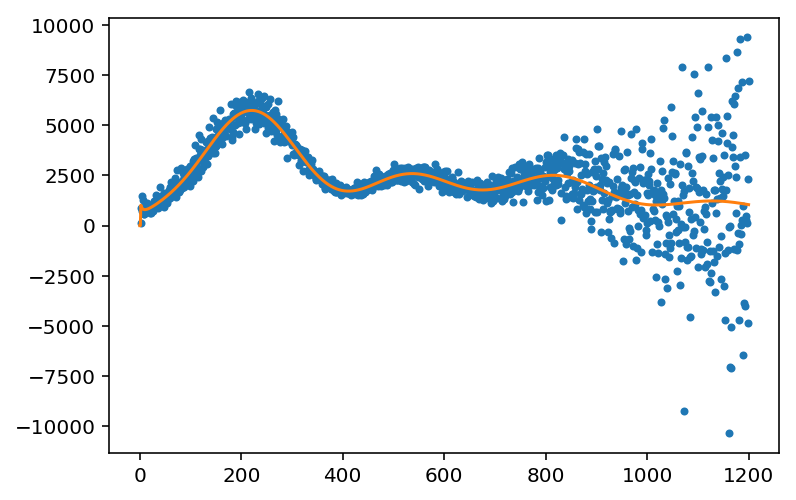

In [60]:
pars=pars0.copy()#starting guesses
pars_temp=pars0.copy()
max_num_iterations = 1000
#Adapted from newton.py (class)
lamb = 0.1
NoiseMat=np.diag((wmap[:,2]**2))

for j in range(max_num_iterations):
    if j == 0:
        delta_chi2=0
    print("Iteration %d of %d: "%(j,max_num_iterations))

        
    while(True):

        grad = []

        pred=(get_spectrum(pars))
        for i in range(len(pars)):
            #The last value sets scale of step sizes "dx" in parameter space
            #Since we are using the two sided limit with doubles (python already converts as appropriate)
            #A dx scale of 1e-8 is near optimal (as we learned in class & assignment 1)
            grad.append(calc_deriv(get_spectrum, pars, i, 1e-8)[2:]) 

        r=(wmap[:,1]-pred[2:]) #1:-1 to match numbers with wmap size, derivatives don't go all the way to the ends

        chi2=((r**2)/wmap[:,2]**2).sum()

        r=np.matrix(r).transpose()

        for jj in range(pars.size):
            if jj != 3: #ignores optical depth, left fixed at tau=0.05
                pars_temp[jj]= pars[jj] + newton_helper(grad,r,NoiseMat, lamb)[jj]
        pred_temp=get_spectrum(pars_temp)
        r_temp=(wmap[:,1]-pred_temp[2:]) #2: to match numbers with wmap size, derivatives don't go all the way to the ends
        chi2_new=((r_temp**2)/wmap[:,2]**2).sum()
        delta_chi2 = chi2_new-chi2

        if delta_chi2 < 0:
            lamb *= 1e-1 #Fit is converging, so shrink scale of descent.
            chi2=chi2_new
            pars=pars_temp.copy()
            print("The parameters are currently "+repr(pars))
            print("Giving a chi2 of: %.2f \n"%chi2)
            break
        if delta_chi2 > 0:
            lamb *= 10 #Fit is not converging, so enlarge scale of descent.
            continue

    if j>1 and (delta_chi2 < 0 and abs(delta_chi2) < 0.01): #new model only very slightly more likely to true
    #if j>1 and (abs(delta_chi2) < 0.1): #new model only very slightly more likely to true
        break
    if j == max_num_iterations-1: 
        print("Reached maximum number of allowed iterations")


    
print("chi 2/NDF: %.3f \n"%(chi2/(wmap[:,1].size-len(pars))))
print("Best fit parameters are "+repr(pars))


#plotting    
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum(pars)
#plt.fill_between(wmap[:,0], cmb[:np.size(wmap[:,2])]-wmap[:,2],cmb[:np.size(wmap[:,2])]+wmap[:,2],color='grey',alpha=0.5)
plt.plot(cmb)

## Findings...

Okay so our best fit after four iterations with a dx of $10^{-8}$ (near optimal for double precision) gives a $\chi^2$/NDF of 1.112

And now if we relax our restriction on the optical depth...


Iteration 0 of 100: 
The parameters are currently array([6.48753525e+01, 2.01872310e-02, 1.01971833e-01, 4.83329369e-02,
       2.00163537e-09, 9.58762045e-01])
Giving a chi2 of: 1627.18 

Iteration 1 of 100: 
The parameters are currently array([6.41470632e+01, 2.02637301e-02, 1.04805296e-01, 3.73112831e-02,
       1.96824287e-09, 9.53336155e-01])
Giving a chi2 of: 1562.63 

Iteration 2 of 100: 
The parameters are currently array([6.39618839e+01, 2.04063834e-02, 1.06671283e-01, 3.41092888e-02,
       1.96369483e-09, 9.51957174e-01])
Giving a chi2 of: 1505.96 

Iteration 3 of 100: 
The parameters are currently array([6.34434383e+01, 2.04136376e-02, 1.06694332e-01, 3.41011072e-02,
       1.96369250e-09, 9.51957136e-01])
Giving a chi2 of: 1462.87 

Iteration 4 of 100: 
The parameters are currently array([6.34434383e+01, 2.04136376e-02, 1.06694332e-01, 3.41011072e-02,
       1.96369250e-09, 9.51957136e-01])
Giving a chi2 of: 1483.14 

chi 2/NDF: 1.226 


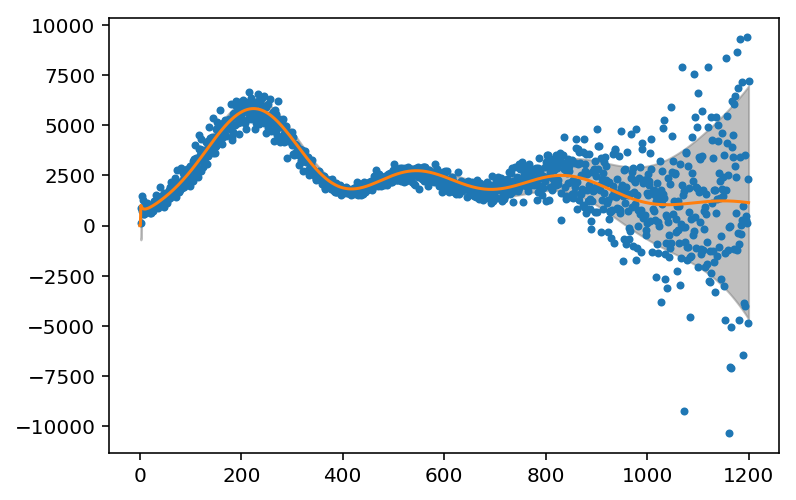

In [48]:
pars=pars0.copy()#starting guesses
max_num_iterations = 100
#Adapted from newton.py (class)
lamb = 0.1
for j in range(max_num_iterations):

    print("Iteration %d of %d: "%(j,max_num_iterations))


    grad = []
    
    pred=(get_spectrum(pars))
    for i in range(len(pars)):
        #The last value sets scale of step sizes "dx" in parameter space
        #Since we are using the two sided limit with doubles (python already converts as appropriate)
        #A dx scale of 1e-8 is near optimal (as we learned in class & assignment 1)
        grad.append(calc_deriv(get_spectrum, pars, i, 1e-8)[1:-1]) 
        
   
    r=(wmap[:,1]-pred[1:-1]) #1:-1 to match numbers with wmap size, derivatives don't go all the way to the ends
    
    chi2=((r**2)/wmap[:,2]**2).sum()
    
    r=np.matrix(r).transpose()

    for jj in range(pars.size):
        #if jj != 3: #ignores optical depth, left fixed at tau=0.05
        pars[jj]= pars[jj] + newton_helper(grad,r)[jj]*lamb
        if j>1 and delta_chi2 < 0:
            lamb *= 1e-1 #Fit is converging, so shrink scale of descent.
            
    print("The parameters are currently "+repr(pars))
    print("Giving a chi2 of: %.2f \n"%chi2)
    if j==0:
        chi2_old=chi2
    elif j>1:
        delta_chi2=chi2-chi2_old
        if j>1 and (delta_chi2 > 0 or abs(delta_chi2) < 0.1): #new model only very slightly more likely to true
        #if j>1 and (abs(delta_chi2) < 0.1): #new model only very slightly more likely to true
            pars=pars_old
            chi2=chi2_old
            break
        pars_old=pars
        chi2_old=chi2
    if j == max_num_iterations-1: 
        print("Reached maximum number of allowed iterations")

   
    
print("chi 2/NDF: %.3f \n"%(chi2/(wmap[:,1].size-len(pars))))

print("Best fit parameters are "+repr(pars))

#plotting    
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum(pars)
#plt.fill_between(wmap[:,0], cmb[:np.size(wmap[:,2])]-wmap[:,2],cmb[:np.size(wmap[:,2])]+wmap[:,2],color='grey',alpha=0.5)
plt.plot(cmb)

## Findings part II...

By freeing up our optical depth parameter our best fit is actually worse... Giving a $\chi^2/NDF$ of 1.226 (something is wrong, maybe?!)

# Problem 3)

This asks for an MCMC of the parameter space, again, adapted from class...

In [104]:
#From class
def take_step(scale_factor=1.0):
    param_scalings=np.asarray([0.1,1e-3,1e-2,1e-3, 1e-11, 1e-2])
    return scale_factor*param_scalings*np.random.randn(len(param_scalings))

def take_step_cov(covmat):
    mychol=np.linalg.cholesky(covmat)
    return np.dot(mychol,np.random.randn(covmat.shape[0]))


In [105]:

x=wmap[:,0]
params_true=np.asarray(pars0)
y_true=get_spectrum(params_true)[1:-1]
noise=wmap[:,2] #errors from WMAP data
y=y_true+np.random.randn(len(x))*noise

params=params_true+take_step()
nstep=50000

chains=np.zeros([nstep,len(params)]) #keep track of where the chain went
chisqvec=np.zeros(nstep)
chisq=np.sum( (y-get_spectrum(params)[1:-1])**2/noise**2)
scale_fac=0.5

for i in range(nstep):
    new_params=params+take_step(scale_fac)
    new_model=get_spectrum(new_params)[1:-1]
    new_chisq=np.sum( (y-new_model)**2/noise**2)
    if(i%100 == 0):
        print("On step %d "%i)
    
    delta_chisq=new_chisq-chisq
    prob=np.exp(-0.5*delta_chisq)
    accept=np.random.rand(1)<prob
    if accept:
        params=new_params
        model=new_model
        chisq=new_chisq
    chains[i,:]=params
    chisqvec[i]=chisq


On step 0 
On step 100 
On step 200 
On step 300 
On step 400 
On step 500 
On step 600 
On step 700 
On step 800 
On step 900 
On step 1000 
On step 1100 
On step 1200 
On step 1300 
On step 1400 
On step 1500 
On step 1600 
On step 1700 
On step 1800 
On step 1900 
On step 2000 
On step 2100 
On step 2200 
On step 2300 
On step 2400 
On step 2500 
On step 2600 
On step 2700 
On step 2800 
On step 2900 
On step 3000 
On step 3100 
On step 3200 
On step 3300 
On step 3400 
On step 3500 
On step 3600 
On step 3700 
On step 3800 
On step 3900 
On step 4000 
On step 4100 
On step 4200 
On step 4300 
On step 4400 
On step 4500 
On step 4600 
On step 4700 
On step 4800 
On step 4900 
On step 5000 
On step 5100 
On step 5200 
On step 5300 
On step 5400 
On step 5500 
On step 5600 
On step 5700 
On step 5800 
On step 5900 
On step 6000 
On step 6100 
On step 6200 
On step 6300 
On step 6400 
On step 6500 
On step 6600 
On step 6700 
On step 6800 
On step 6900 
On step 7000 
On step 7100 
On s

Best fit parameters are 
array([6.40197011e+01, 2.03690021e-02, 1.05889744e-01, 3.25451919e-02,
       1.99255004e-09, 9.64336680e-01])
Best fit errors are 
array([6.33435359e-01, 4.28482764e-04, 2.29894219e-03, 8.61926107e-03,
       3.96646621e-11, 9.34882431e-03])


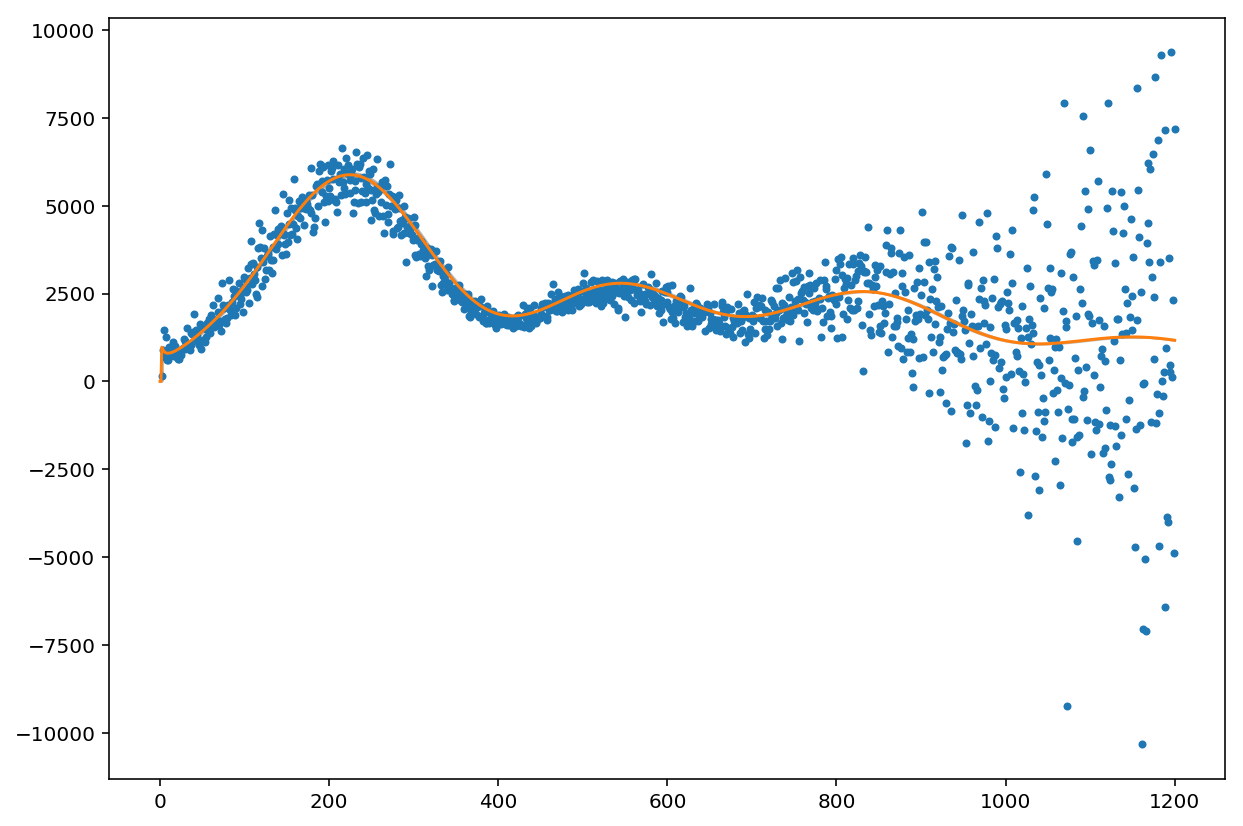

In [106]:
fit_params=np.mean(chains,axis=0)
spread=np.std(chains, axis=0)
print("Best fit parameters are \n"+repr(fit_params))
print("Best fit errors are \n"+repr(spread))

#plotting    
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum(fit_params)
plt.fill_between(wmap[:,0], get_spectrum(fit_params-spread)[1:-1],get_spectrum(fit_params+spread)[1:-1],color='grey',alpha=0.5)
plt.plot(cmb)


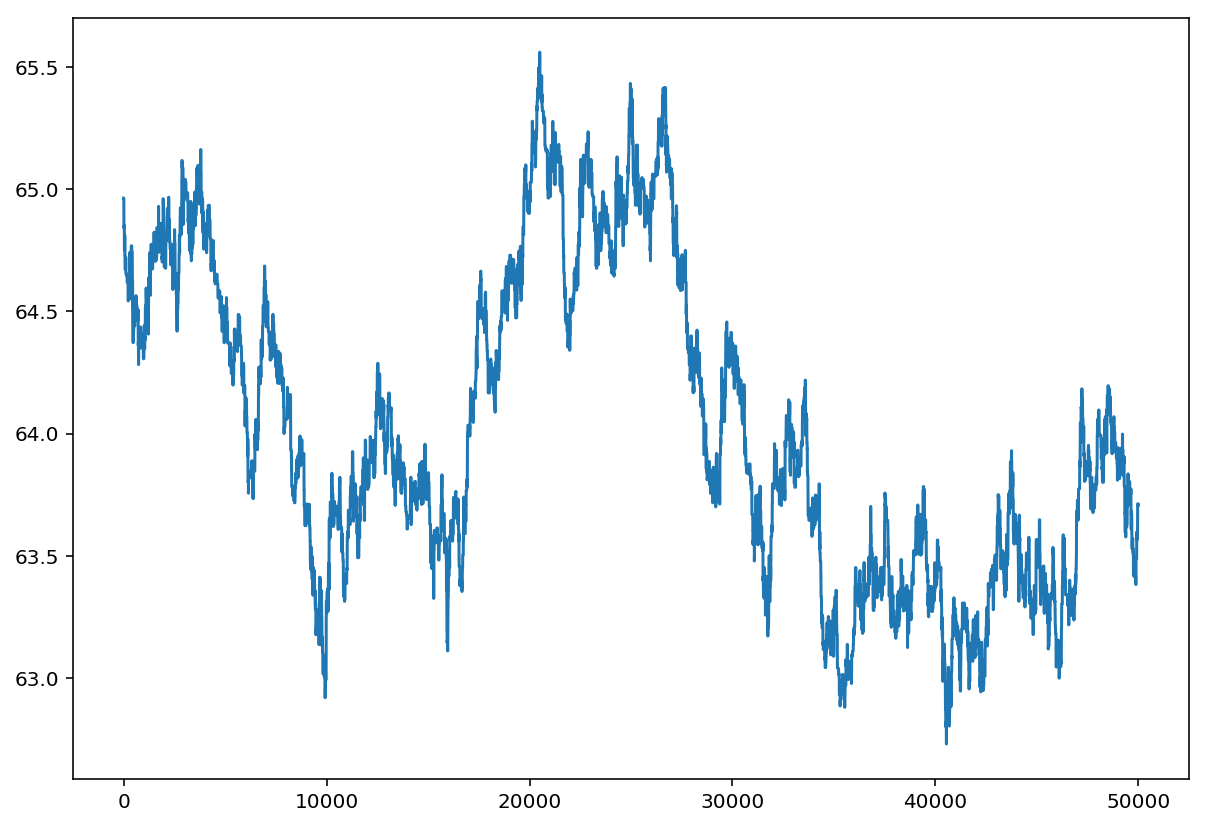

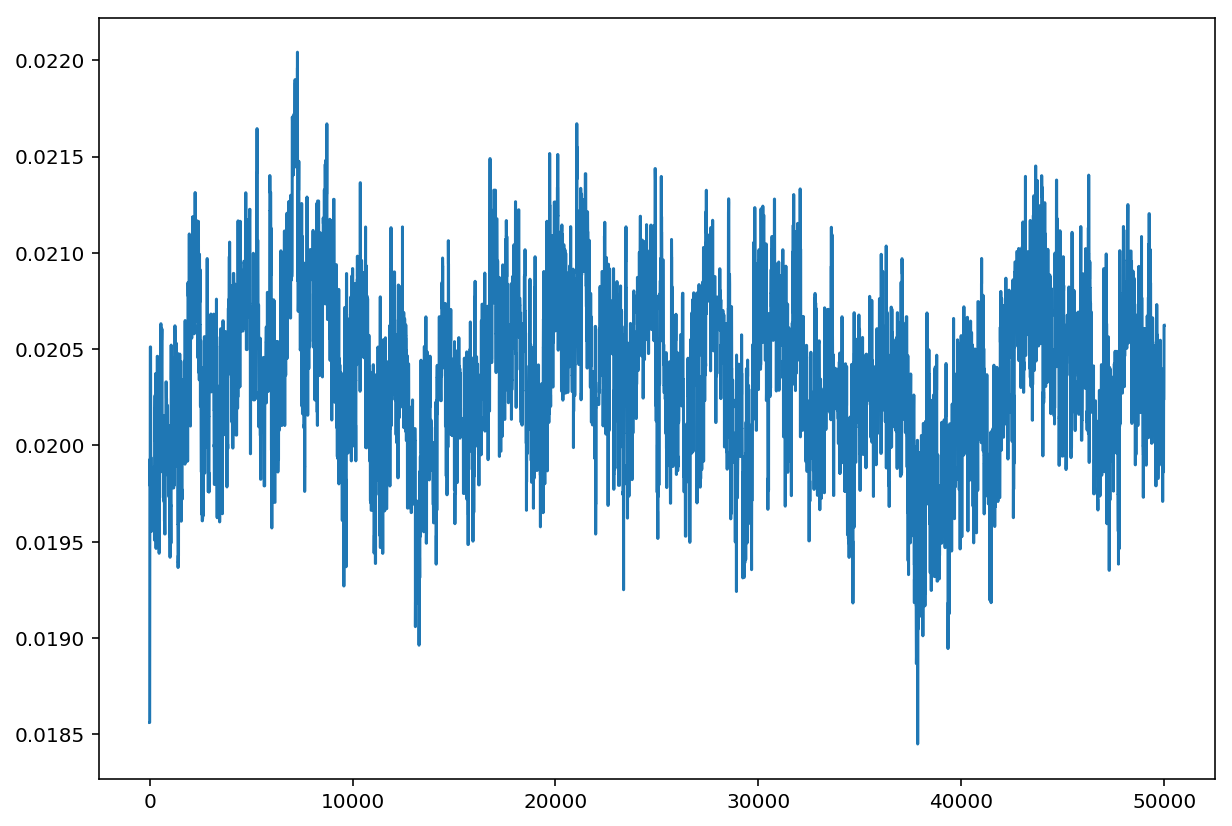

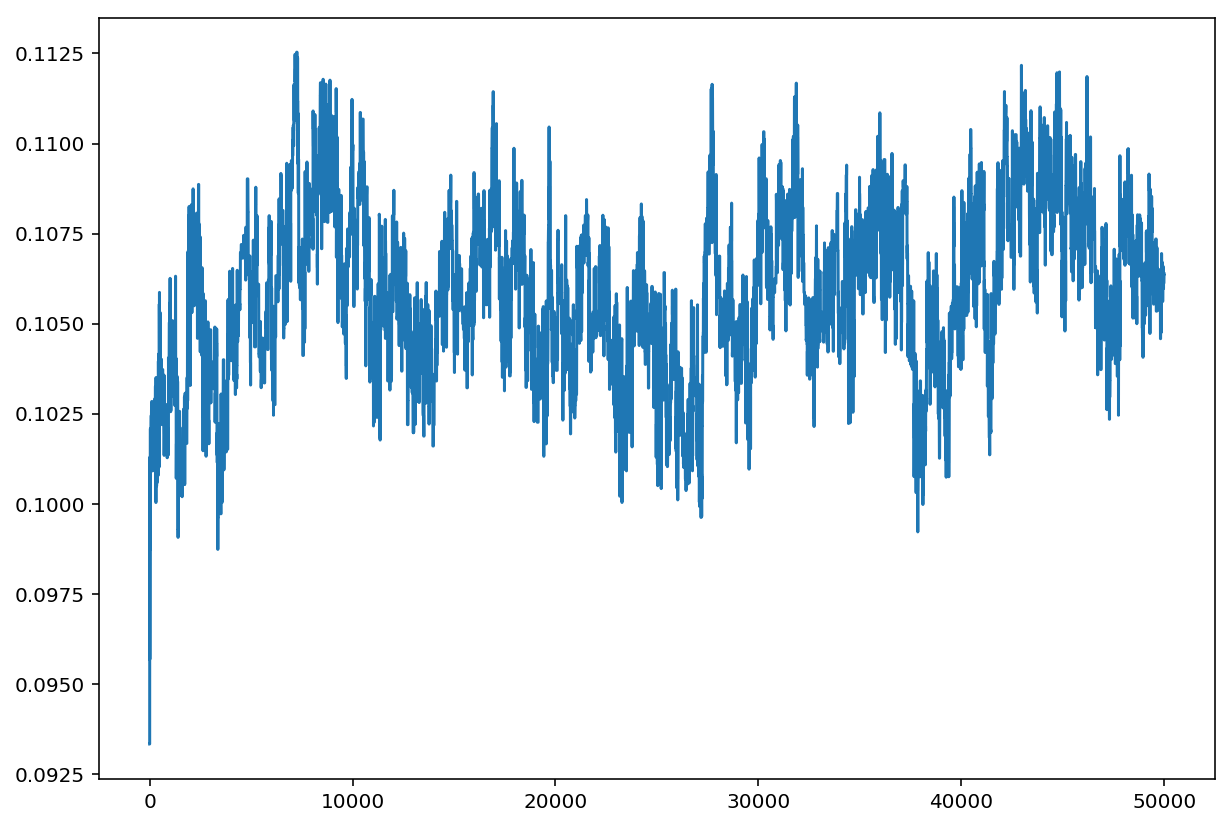

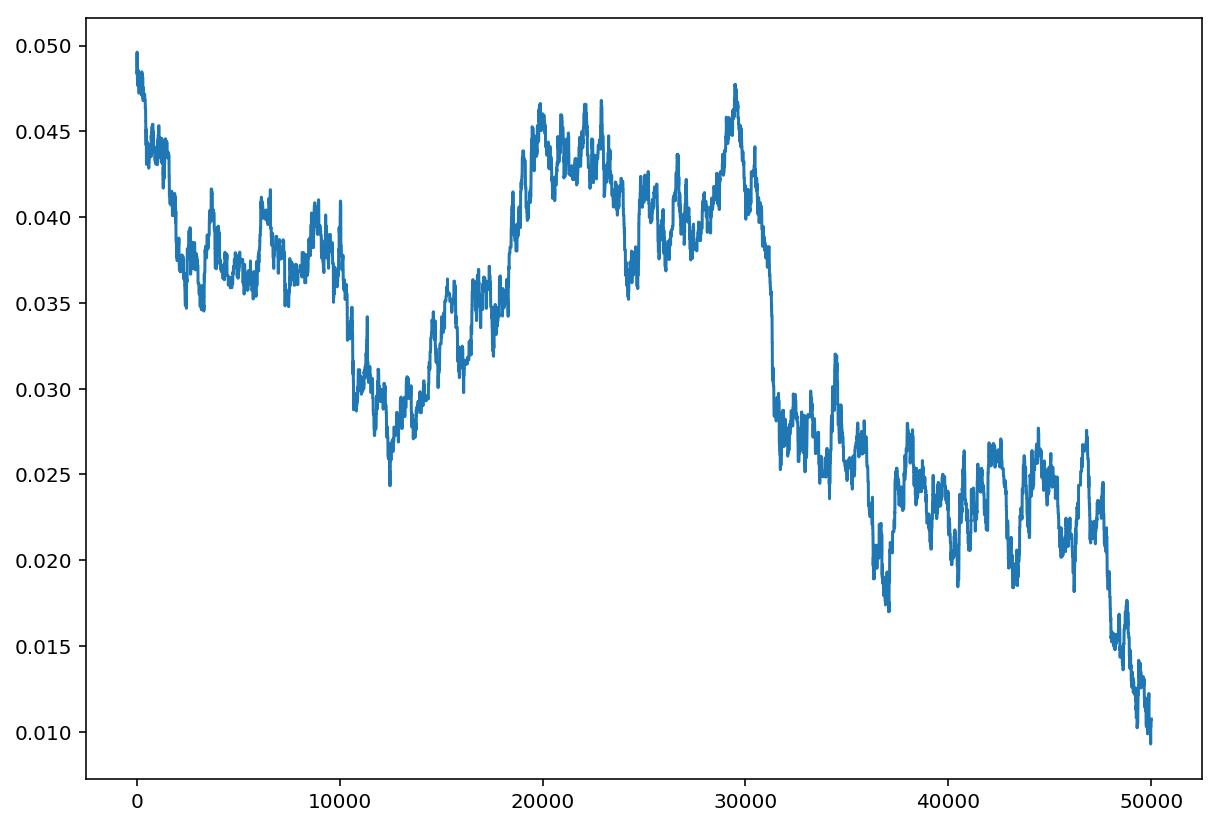

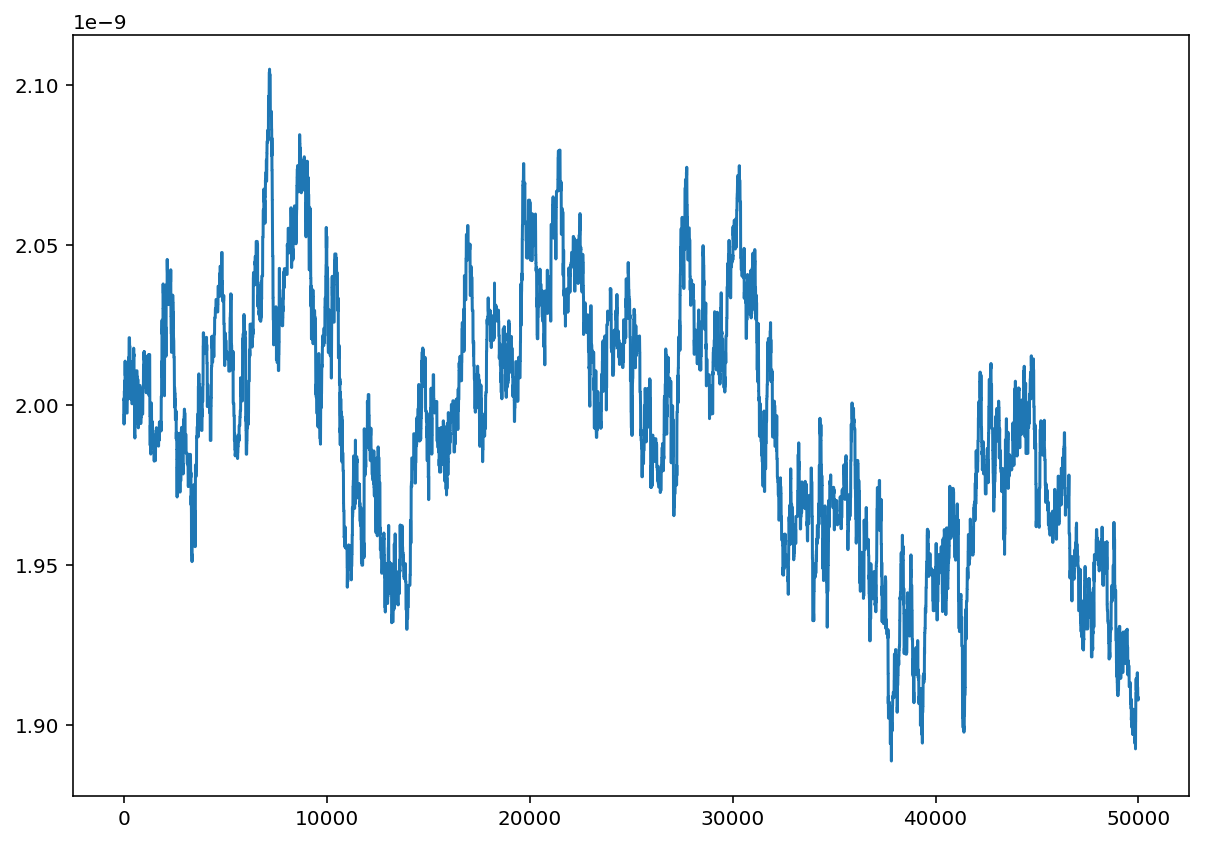

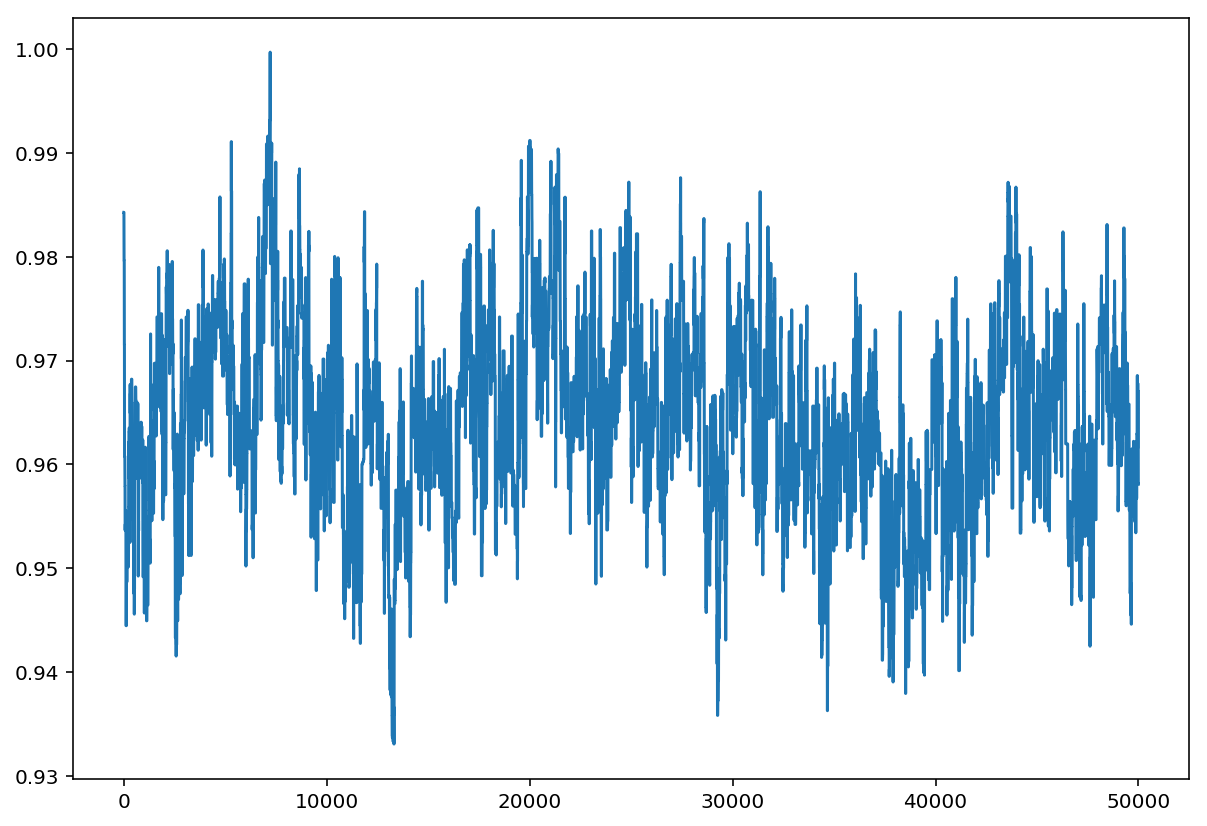

In [107]:
plt.plot(chains[:,0])
plt.show()
plt.plot(chains[:,1])
plt.show()
plt.plot(chains[:,2])
plt.show()
plt.plot(chains[:,3])
plt.show()
plt.plot(chains[:,4])
plt.show()
plt.plot(chains[:,5])
plt.show()

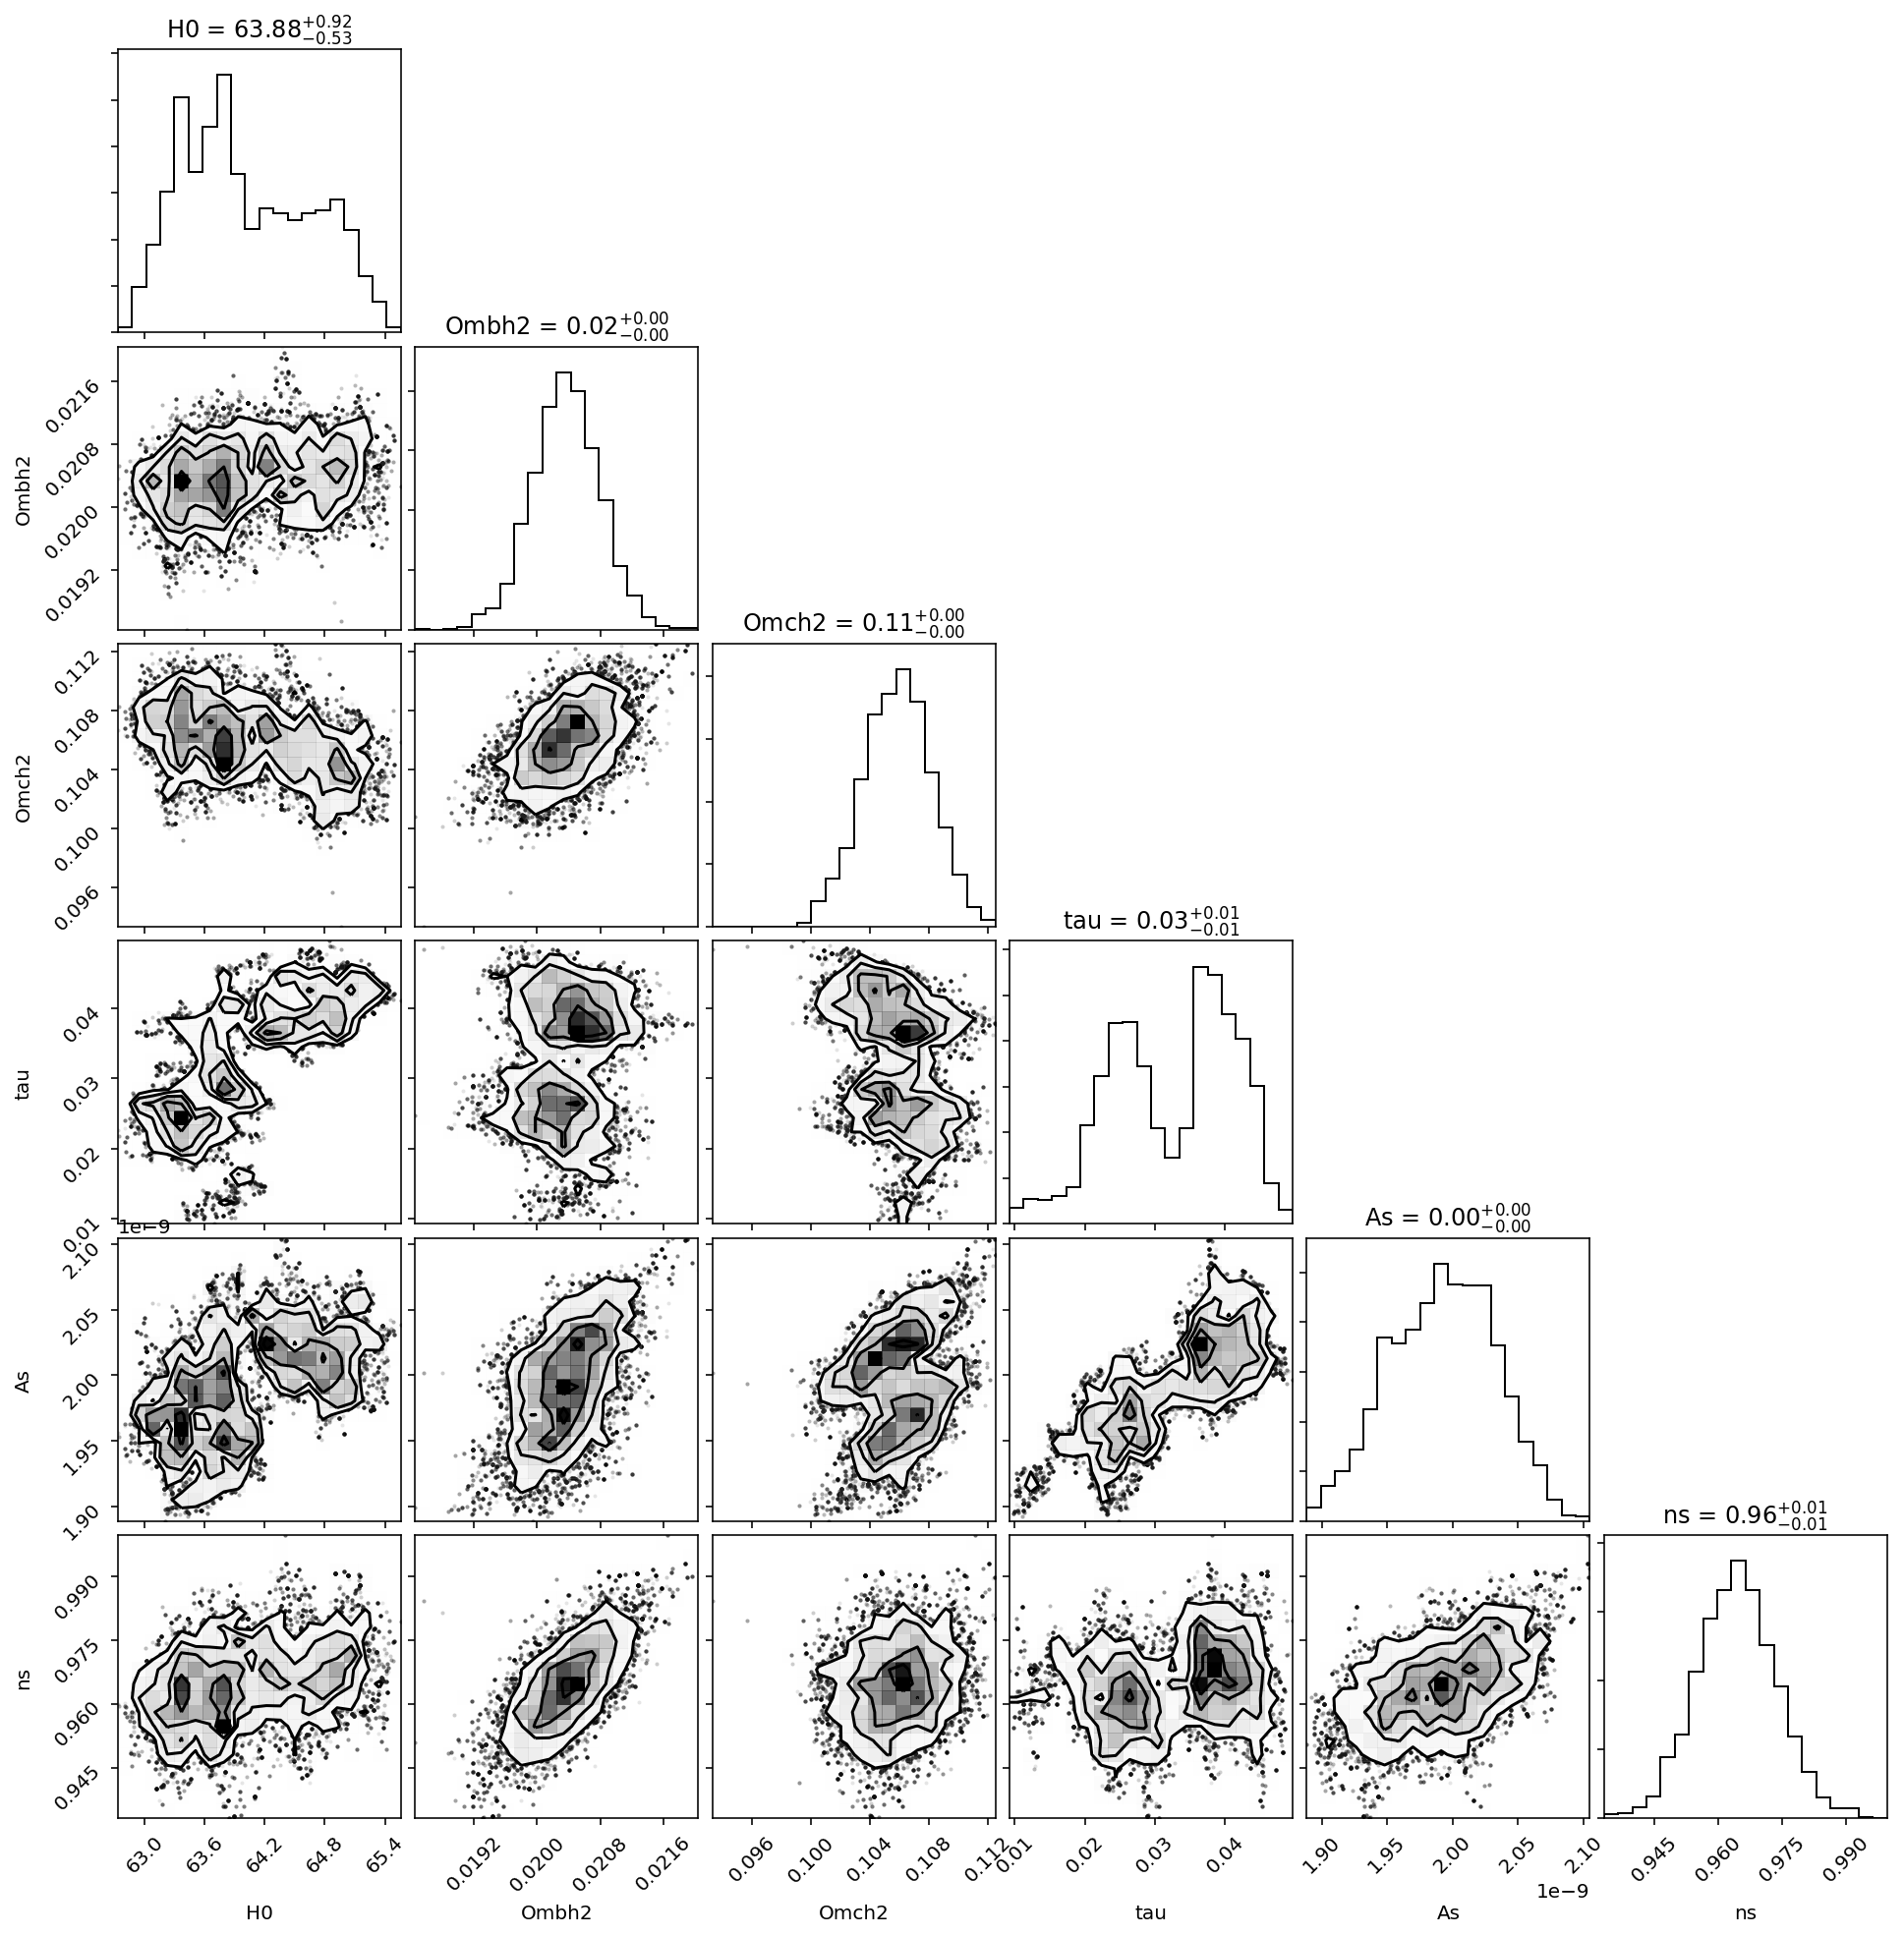

In [122]:
#Or more succinctly 
import corner
labels = ['H0','Ombh2','Omch2','tau','As','ns']

#fig = corner.corner(chains,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
fig = corner.corner(chains,show_titles=True,labels=labels,plot_datapoints=True)
#corner.corner(chains)

np.save("chains", chains)

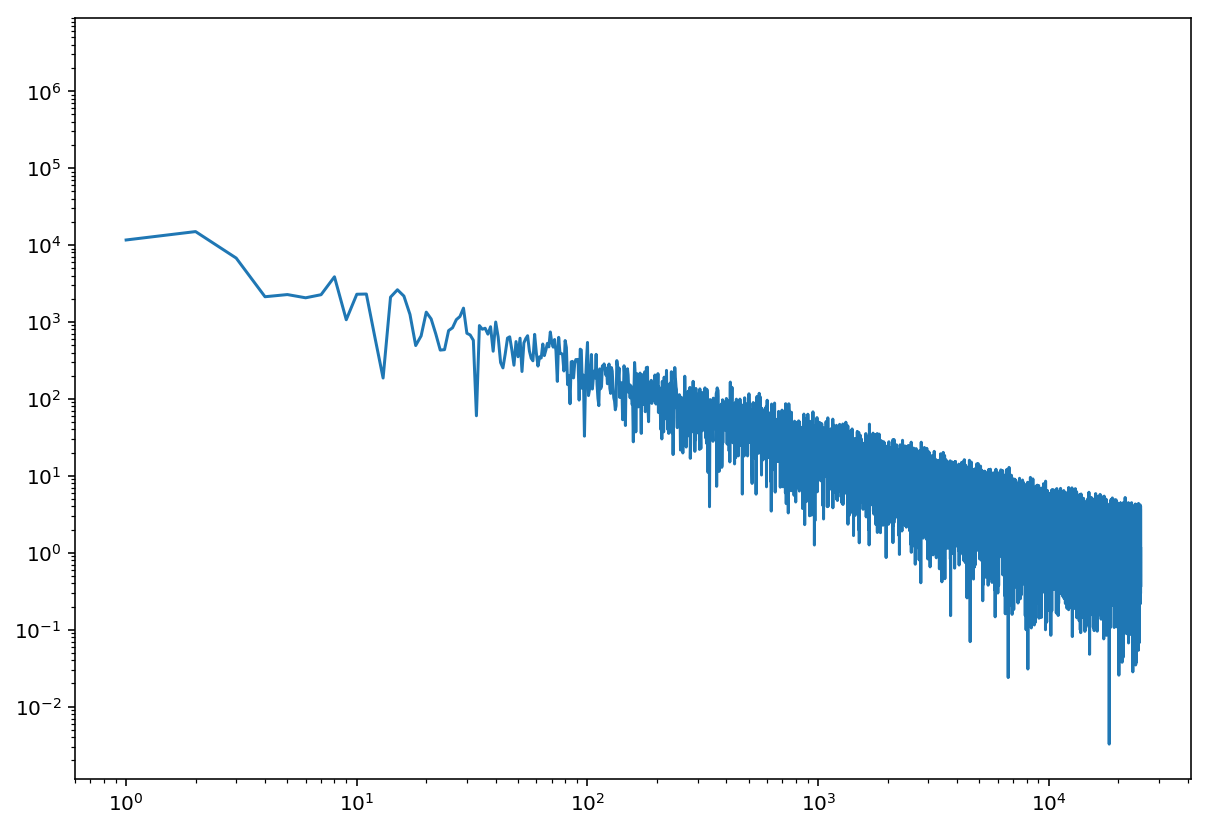

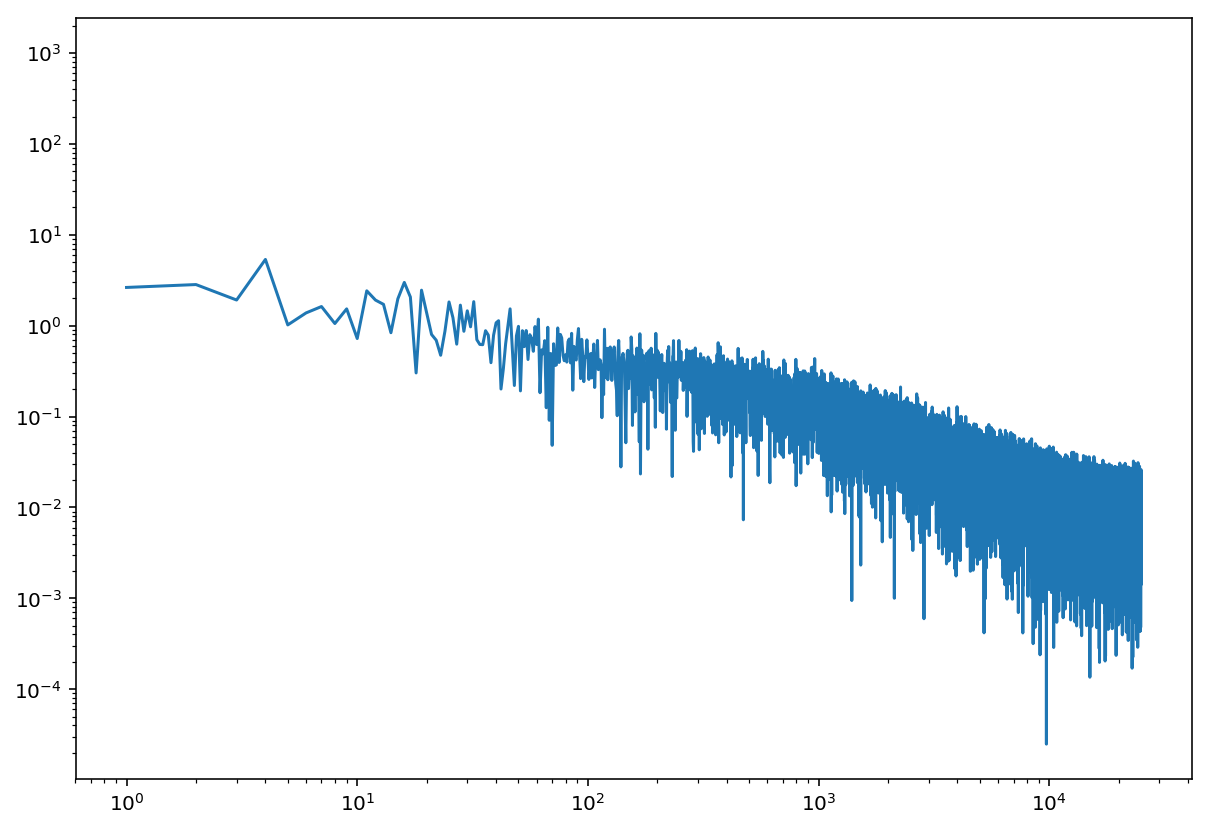

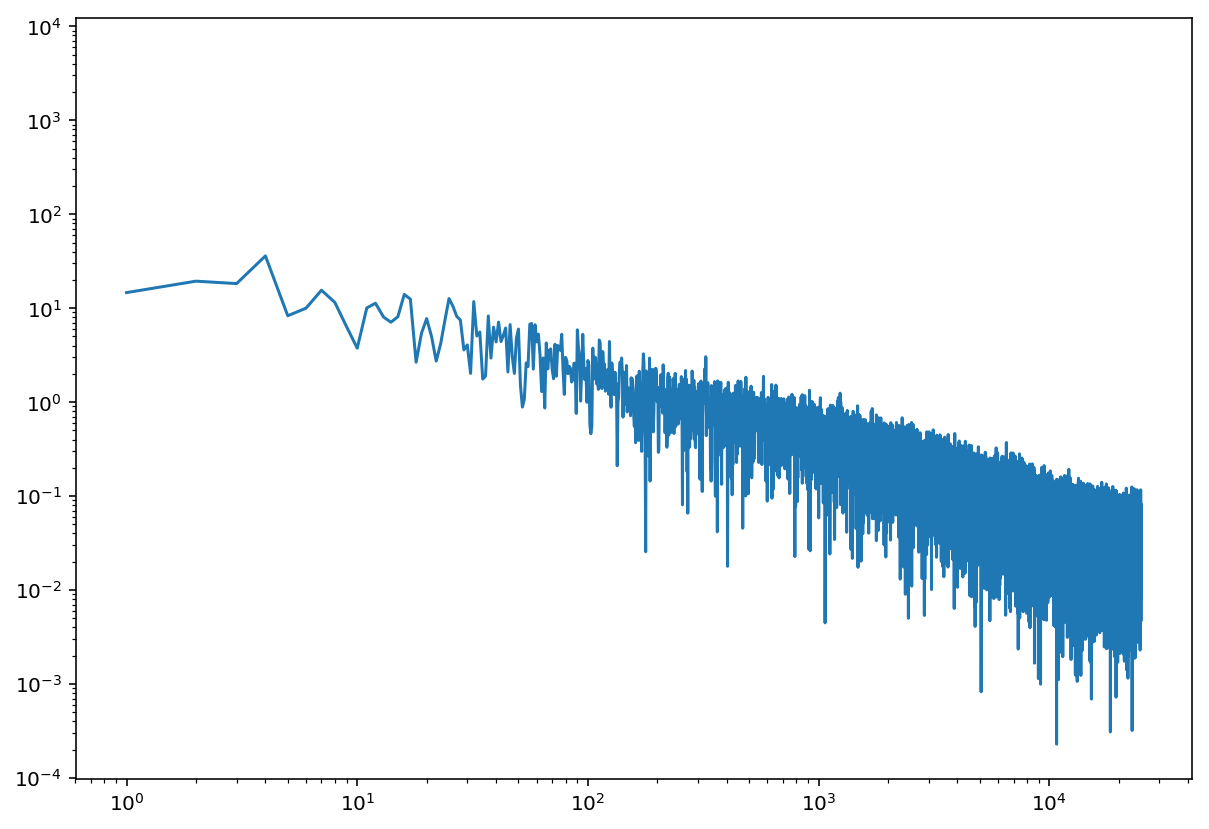

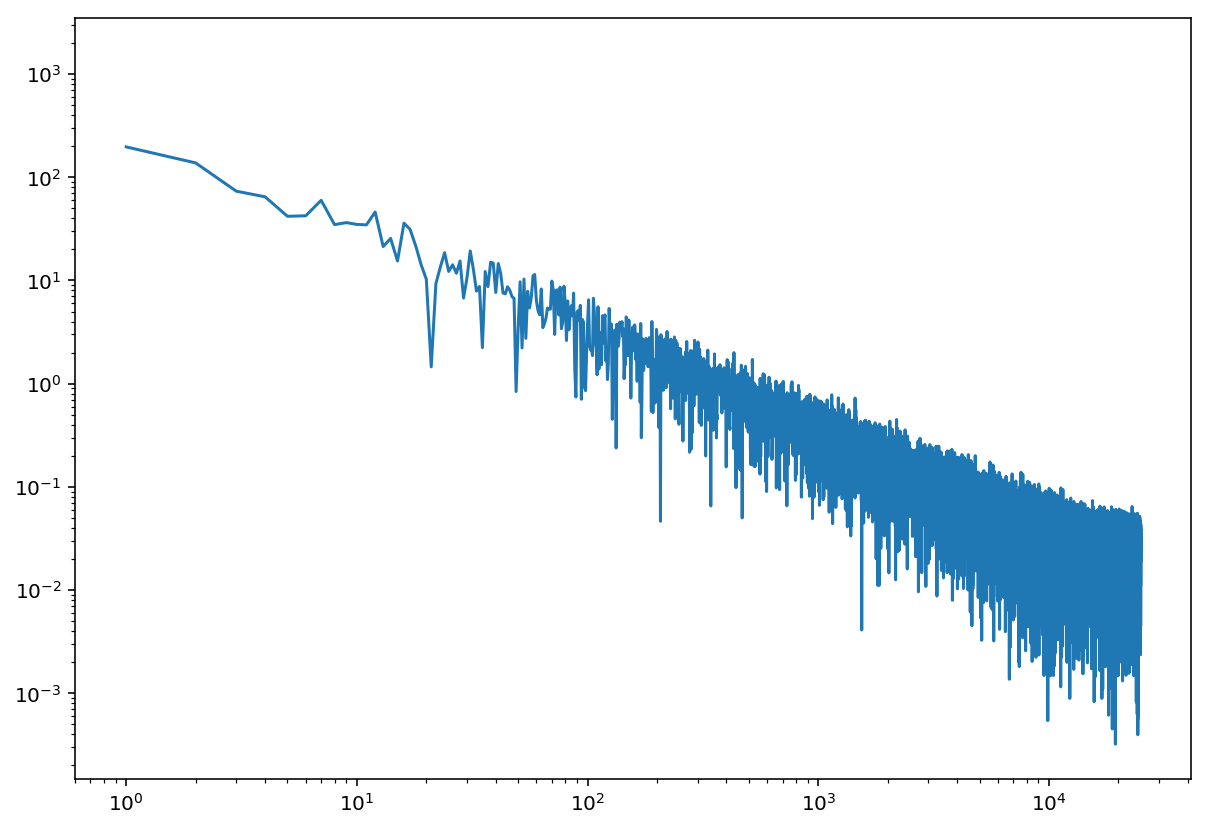

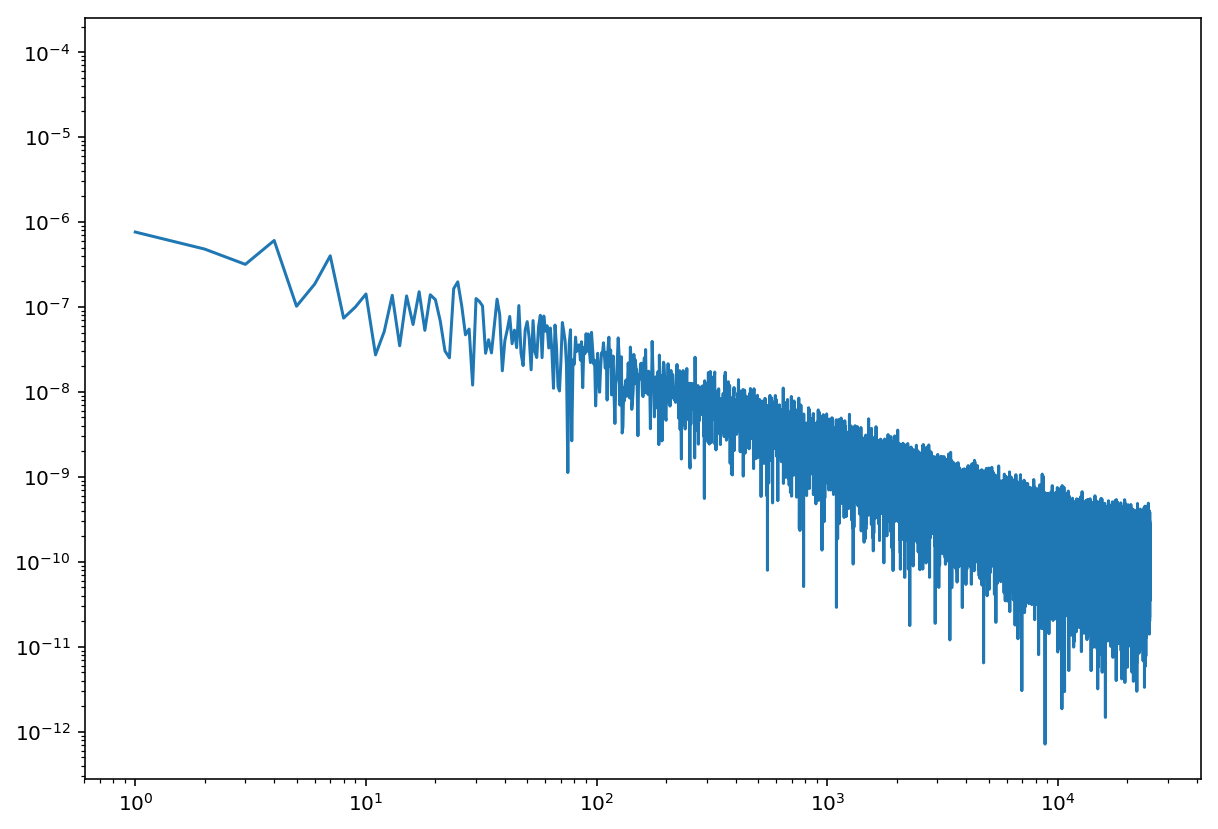

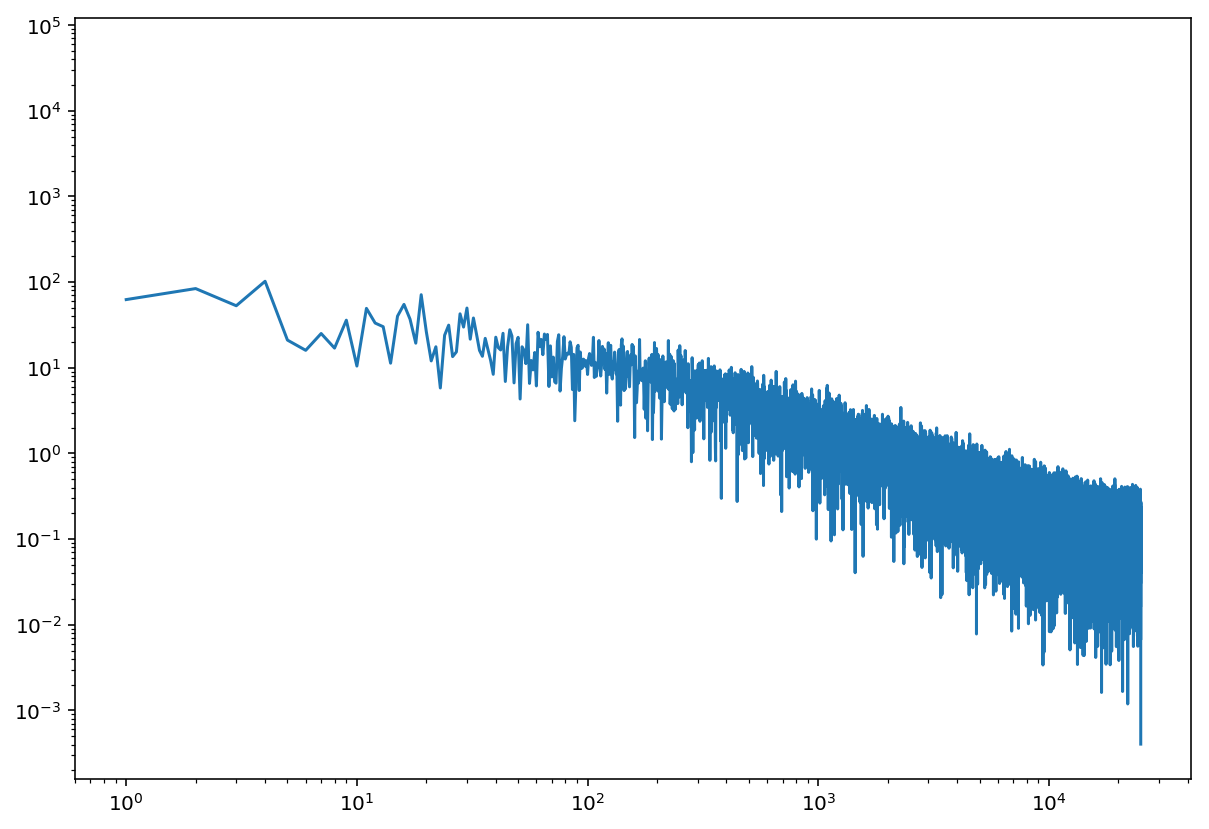

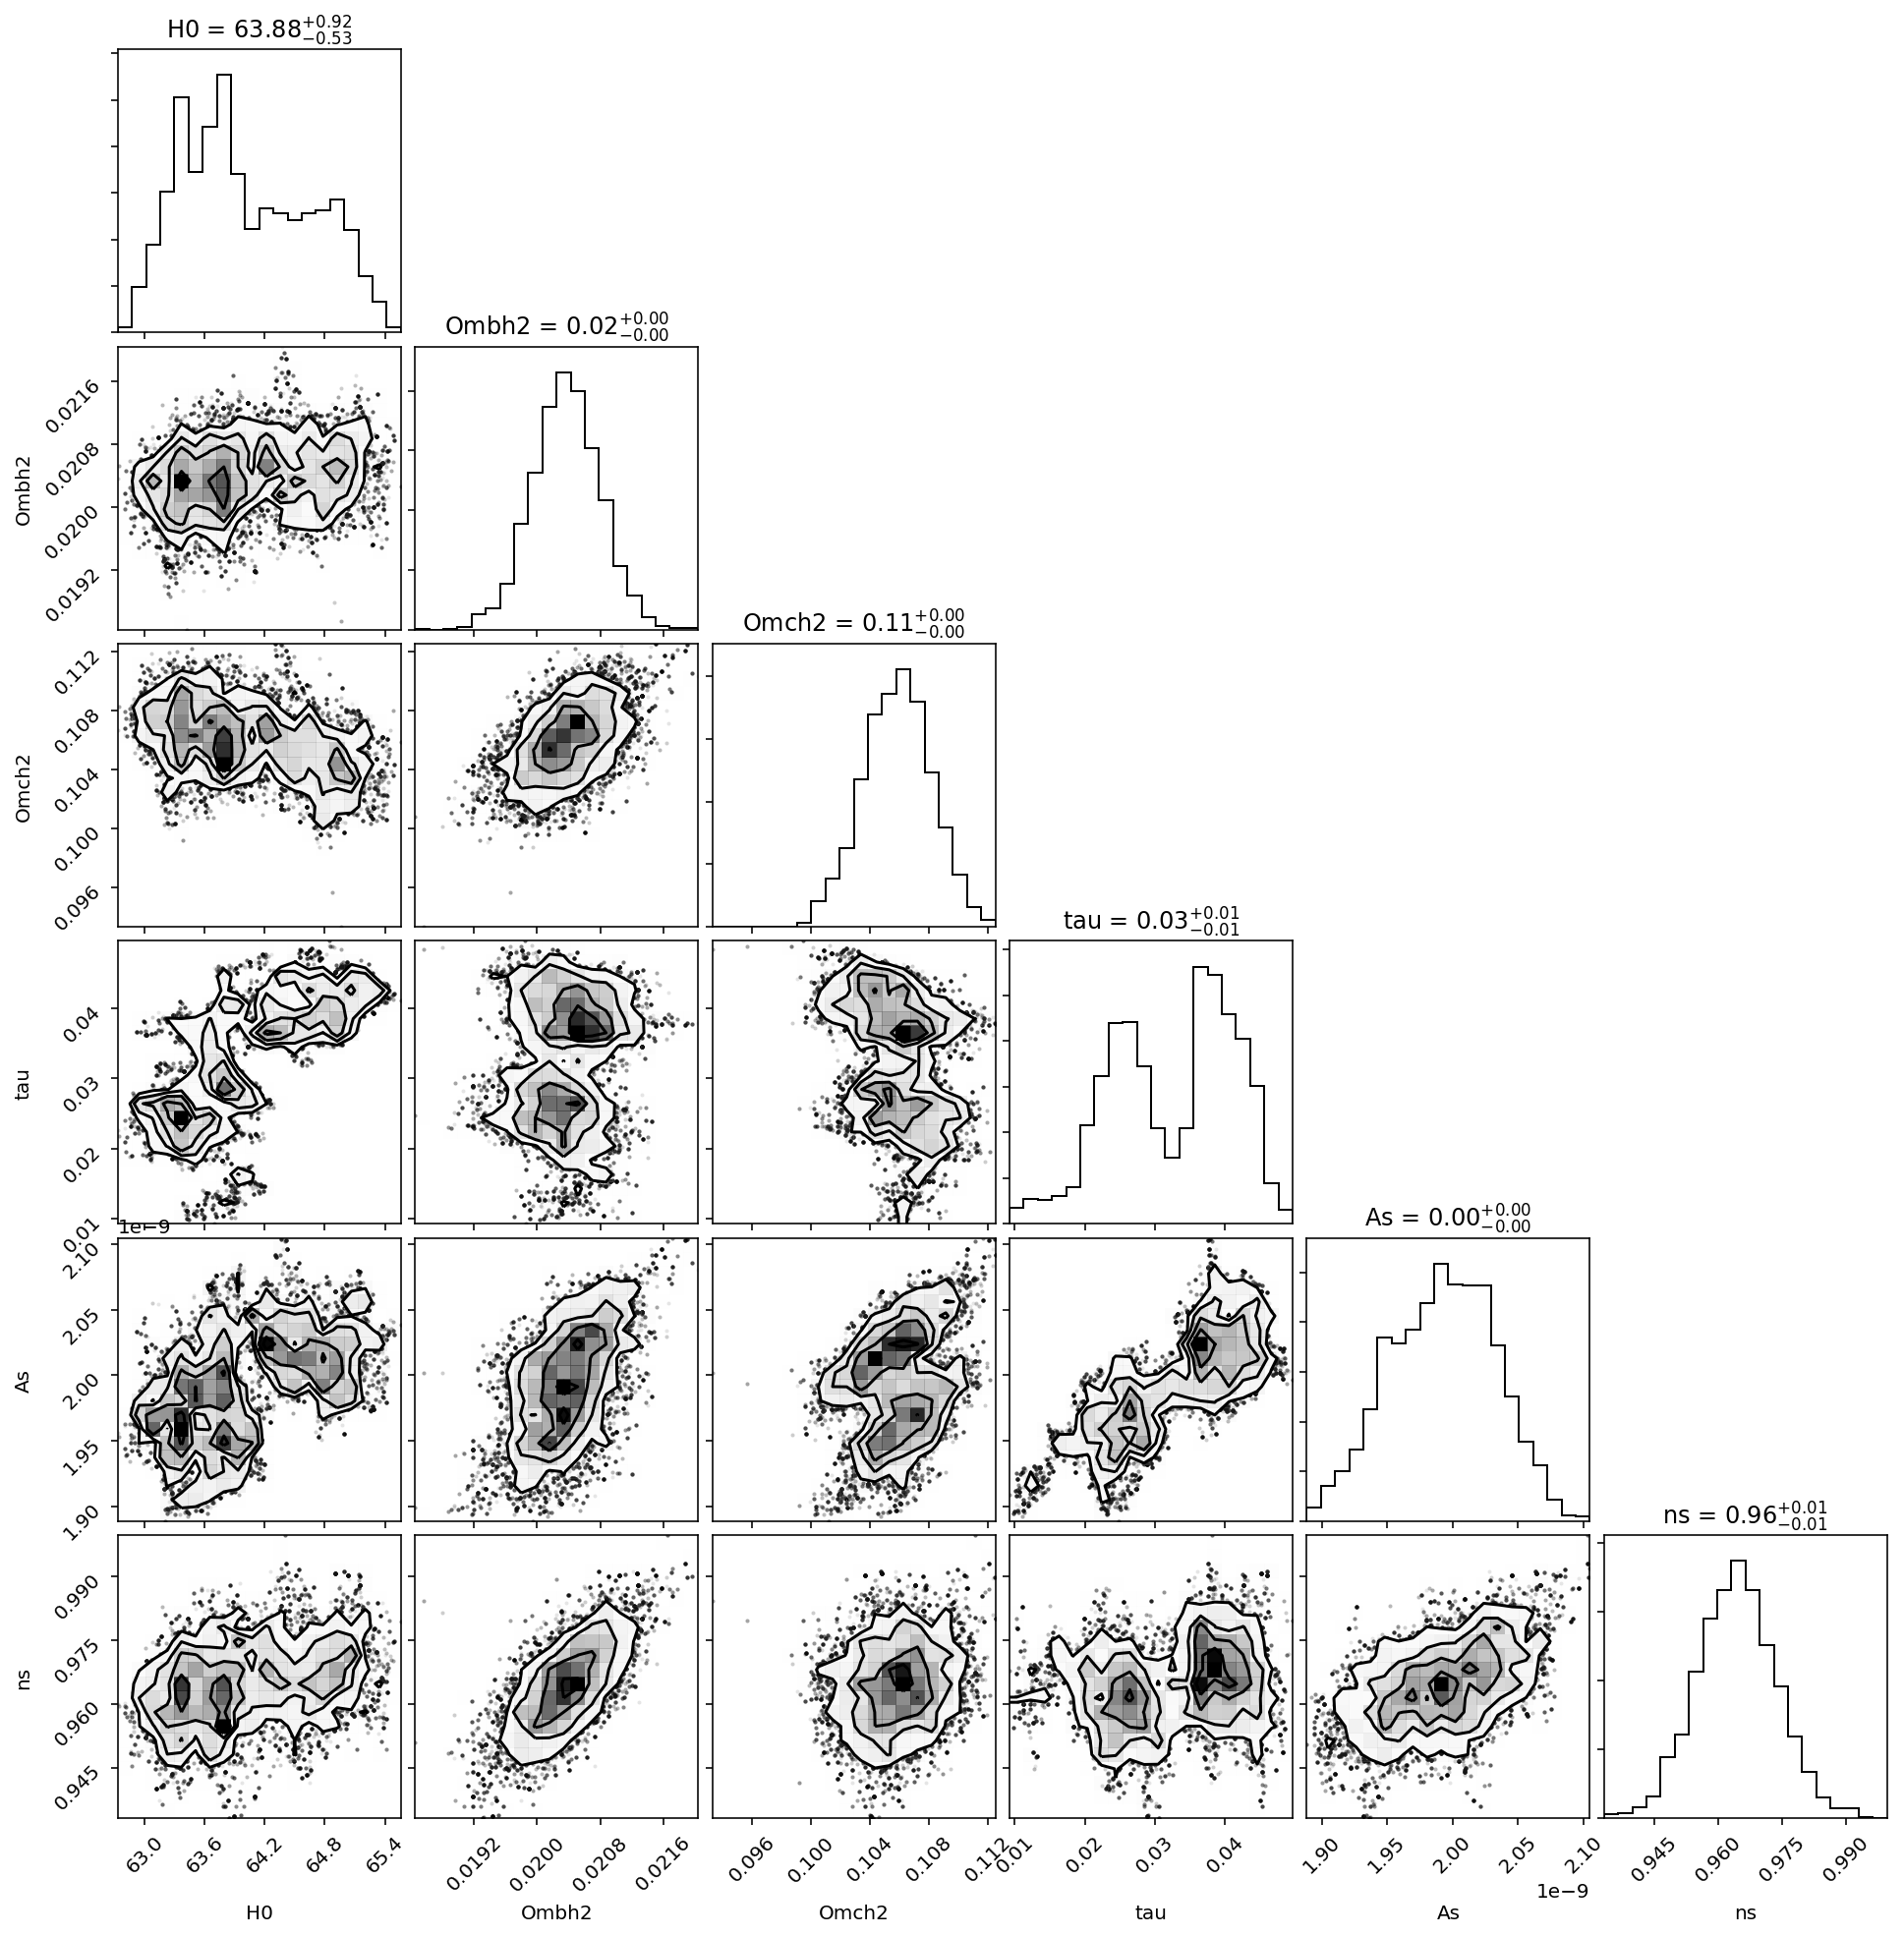

In [125]:
#chains2 = np.load("chains_original.npy")
#chains2 = np.load("chains.npy")
chains2 = chains2[:,:][nstep/2:]

plt.loglog(abs(np.fft.rfft(chains2[:,0])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains2[:,1])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains2[:,2])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains2[:,3])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains2[:,4])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains2[:,5])))
plt.show()

fig = corner.corner(chains2,show_titles=True,labels=labels,plot_datapoints=True)



In [126]:
#Now to use covariance matrix and be a bit smarter in how we move through the parameter space
#By taking steps using the matrix, we are more efficient in our sampling coverage of the parameter space
mycov=np.cov(chains2[nstep/2:,:].T) #Take chain from n/2 steps to get past the burn in
npar=len(params_true)
chains_new=np.zeros([nstep,npar])
params=np.mean(chains,axis=0)
chisq_new=np.sum( (y-get_spectrum(params)[1:-1])**2/noise**2)
scale_fac_new=0.5
chisqvec_new=np.zeros(nstep)

for i in range(nstep):
    while(new_params[3]<0): #rejects negative tau values 
        new_params=params+take_step_cov(mycov)*scale_fac
    new_model=get_spectrum(new_params)[1:-1]
    new_chisq=np.sum( (y-new_model)**2/noise**2)
    
    delta_chisq=new_chisq-chisq
    prob=np.exp(-0.5*delta_chisq)
    accept=np.random.rand(1)<prob
    if accept:
        params=new_params
        model=new_model
        chisq_new=new_chisq
    chains_new[i,:]=params
    chisqvec_new[i]=chisq_new
    if(i%100 == 0):
        print("On step %d "%i)
        np.save("chains_cov.npy", chains_new)
        current = i
    


On step 0 
On step 100 


KeyboardInterrupt: 

In [130]:
chains_new = np.load("chains_cov.npy")
#Again, let's check out the corner plots. 
labels = ['H0','Ombh2','Omch2','tau','As','ns']
chains_new[:current,:].shape
#fig = corner.corner(chains,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
fig = corner.corner(chains_new,show_titles=True,labels=labels,plot_datapoints=True)


(100, 6)

And just to make sure everything has converged properly... Let's look at the fourier transforms of the chains, and look at the individual parameters.

In [ ]:
#Examining the burn-in and seeings where to cut off 



In [ ]:
#Looking at the Fourier tranforms

plt.loglog(abs(np.fft.rfft(chains_new[:,0])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains_new[:,1])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains_new[:,2])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains_new[:,3])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains_new[:,4])))
plt.show()
plt.loglog(abs(np.fft.rfft(chains_new[:,5])))
plt.show()


In [ ]:
#Account for burn in by ignoring first portion 

fit_params2=np.mean(chains_new,axis=0)
spread2=np.std(chains_new, axis=0)
print("Best fit parameters are \n"+repr(fit_params2))
print("Best fit errors are \n"+repr(spread2))

#plotting    
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb2=get_spectrum(fit_params2)
plt.fill_between(wmap[:,0], get_spectrum(fit_params2-spread2)[1:-1],get_spectrum(fit_params2+spread2)[1:-1],color='grey',alpha=0.5)
plt.plot(cmb2)